In [1]:
# import datacube
import numpy as np
import sys
import rioxarray as rio
import geopandas as gpd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model

from dask.distributed import Client
client = Client()
client


2023-02-14 14:54:55.510083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 14:54:59.383516: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-02-14 14:54:59.383532: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 14:55:05.760745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No s

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43833,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.53 GiB
Comm: tcp://127.0.0.1:38681,Total threads: 3
Dashboard: http://127.0.0.1:38823/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:35805,


In [2]:
# load raster 
img_masked = rio.open_rasterio("Rasters/phenoshapeAll_masked.tif")#, chunks={'band': 1, 'x': 250, 'y': 250})
img_masked

# load shapefile with geopandas
#shp = gpd.read_file('SHP/Suisun_mask.shp')

# get shapefile geometry
#shp_geom = shp.geometry

# mask raster with shapefile
#img_masked = img.rio.clip(shp_geom)

<xarray.DataArray (band: 52, y: 2207, x: 2522)>
[289434808 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * x            (x) float64 5.756e+05 5.757e+05 ... 6.008e+05 6.009e+05
  * y            (y) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
img_masked

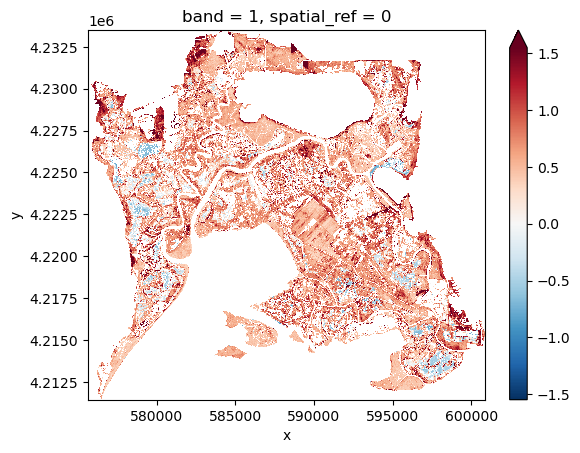

In [3]:
img_masked.isel(band=0).plot(robust=True)

In [9]:
# save masked raster
img_masked.rio.to_raster("phenoshapeAll_masked.tif")

In [11]:
del img, shp

In [4]:
# Convert the raster data to a 2D array and re-organize the data
data = img_masked.stack(z=('y','x'))
data =  data.transpose('z', 'band')
data

<xarray.DataArray (z: 5566054, band: 52)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
  * x            (z) float64 5.756e+05 5.757e+05 ... 6.008e+05 6.009e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
# delete rows with NaN values in data
data_na = data.dropna(dim='z', how='any')
data_na

<xarray.DataArray (z: 1912372, band: 52)>
array([[0.91029885, 0.53379415, 0.61497548, ..., 0.30737023, 0.44313597,
        0.21786839],
       [0.89855408, 0.50716325, 0.55885528, ..., 0.29872634, 0.36707739,
        0.21136648],
       [1.2315948 , 0.72595916, 0.71138568, ..., 0.35451727, 0.50528012,
        0.22241865],
       ...,
       [0.40613218, 0.42860995, 0.53054263, ..., 0.10384882, 0.12576546,
        0.06603447],
       [0.54676543, 0.50873861, 0.5358006 , ..., 0.31515085, 0.44378796,
        0.46973067],
       [0.24204703, 0.49306816, 0.5381456 , ..., 0.19810886, 0.4008571 ,
        0.1531231 ]])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
  * x            (z) float64 5.841e+05 5.841e+05 ... 5.765e+05 5.765e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
del data, img_masked

In [8]:
# Define the number of inputs and the size of the encoding layer
input_dim = data_na.shape[-1]
encoding_dim = 3

In [9]:
# Define the input layer
input_layer = Input(shape=(input_dim,))

# Define the encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Define the decoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

2023-02-14 14:56:46.094539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-02-14 14:56:46.103397: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-14 14:56:46.103467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pop-os
2023-02-14 14:56:46.103478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pop-os
2023-02-14 14:56:46.103625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-02-14 14:56:46.103681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 52

In [10]:
# Train the autoencoder on the input data using the data without NaN values
autoencoder.fit(data_na, data_na,
                epochs=50,
                batch_size=256,
                shuffle=True)

Epoch 1/50
7471/7471 [==============================] - 22s 3ms/step - loss: -28.7960
Epoch 2/50
7471/7471 [==============================] - 20s 3ms/step - loss: -172.3217
Epoch 3/50
7471/7471 [==============================] - 23s 3ms/step - loss: -426.3146
Epoch 4/50
7471/7471 [==============================] - 21s 3ms/step - loss: -787.0475
Epoch 5/50
7471/7471 [==============================] - 22s 3ms/step - loss: -1253.3928
Epoch 6/50
7471/7471 [==============================] - 20s 3ms/step - loss: -1824.3840
Epoch 7/50
7471/7471 [==============================] - 20s 3ms/step - loss: -2499.6436
Epoch 8/50
7471/7471 [==============================] - 20s 3ms/step - loss: -3280.0994
Epoch 9/50
7471/7471 [==============================] - 21s 3ms/step - loss: -4162.9712
Epoch 10/50
7471/7471 [==============================] - 20s 3ms/step - loss: -5147.9819
Epoch 11/50
7471/7471 [==============================] - 20s 3ms/step - loss: -6238.0479
Epoch 12/50
7471/7471 [============

In [11]:
import pickle

# save the model to disk
filename = 'autoencoder.sav'
pickle.dump(autoencoder, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-14 15:13:56        24760
config.json                                    2023-02-14 15:13:56         1613
metadata.json                                  2023-02-14 15:13:56           64


In [14]:
#del data_na

data = rio.open_rasterio("Rasters/phenoshapeAll_masked.tif")
data = data.stack(z=('y','x'))
data = data.transpose('z', 'band')

# Define the encoder model
encoder = Model(input_layer, encoded)

# Reduce the dimensionality of the input data using the encoder
encoded_data = encoder.predict(data)

173940/173940 [==============================] - 256s 1ms/step


In [15]:
encoded_data.shape

(5566054, 3)

In [16]:
# transform the encoded data to a 3D array
# template with the xarray shape
template = data[:, 1:4]
template
# assign the encoded data to the template
output_array = template.copy(data=encoded_data)
# unstack xarray to get the original shape
prediction = output_array.unstack()
prediction

<xarray.DataArray (band: 3, y: 2207, x: 2522)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
  * x            (x) float64 5.756e+05 5.757e+05 ... 6.008e+05 6.009e+05
  * band         (band) int64 2 3 4
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

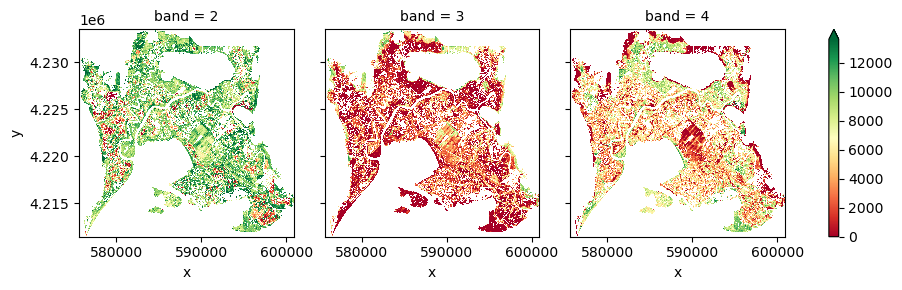

In [18]:
# plot all bands of prediction side by side
prediction.plot.imshow(col='band', col_wrap=3, cmap='RdYlGn', robust=True)
plt.savefig('figures/Autoencoder_components.png', dpi=300)

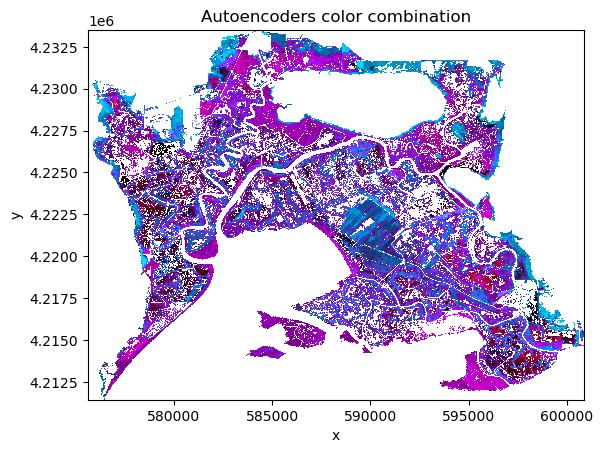

In [20]:
# RGB composition plot of the encoded data
prediction[[2, 1, 0], :, :].plot.imshow(robust=True)
plt.title('Autoencoders color combination')
plt.savefig('figures/Autoencoder_color_combination.png', dpi=300)

In [21]:
# save prediction to disk
prediction.rio.to_raster("autoencoders.tif")